In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch. utils.data import DataLoader

torch.manual_seed(8)
torch.cuda.manual_seed_all(8)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

batch_size = 128
test_batch_size = 256

# Transformations
data_transformations = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])
data_transformations_for_mnist = transforms.Compose([
                           transforms.Grayscale(3),
                           transforms.Resize(32),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])


# Data Source
svhn_train = datasets.SVHN('./data', split='train', download=True,
                       transform=data_transformations)
svhn_test = datasets.SVHN('./data', split='test', download=True,
                       transform=data_transformations)
mnist_test = datasets.MNIST('./data', train=False, download=True,
                            transform=data_transformations_for_mnist)


# Data loaders
train_loader_svhn = DataLoader(svhn_train,
                          batch_size=batch_size, shuffle=True)
test_loader_svhn = DataLoader(svhn_test,
                         batch_size=test_batch_size, shuffle=True)
test_loader_mnist = DataLoader(mnist_test,
                         batch_size=test_batch_size, shuffle=True)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


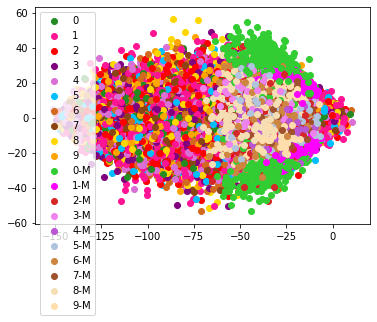

In [0]:
from matplotlib import pyplot as plt


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

fig, ax = plt.subplots()

for batch_idx, (data, target) in enumerate(train_loader_svhn):
        data, target = data.to(device), target.to(device)
        bs = data.size(0)
        data = data.view(bs, 3*32*32)
        x = torch.svd(data)
        z = torch.eye(x[1].size(0))
        z = z * x[1]
        #z = x[2].unsqueeze(0).expand(data.size())
        x = torch.mm(x[0], z)[:,0:2]
        #print(x.size())
       
        colors = ["forestgreen", "deeppink", "red", "purple", "orchid", "deepskyblue", "chocolate", "saddlebrown", "gold", "orange"]
        for i in range(10):
            data_i = torch.masked_select(x, torch.unsqueeze(target == i, 1).expand(x.size())).view(-1,2)
            if batch_idx==0:
                ax.scatter(data_i[:,0], data_i[:,1], c=colors[i], label=i)
            else:
                ax.scatter(data_i[:,0], data_i[:,1], c=colors[i])


for batch_idx, (data, target) in enumerate(test_loader_mnist):
        data, target = data.to(device), target.to(device)
        bs = data.size(0)
        data = data.view(bs, 3*32*32)
        bs = data.size(0)
        x = torch.svd(data)
        z = torch.eye(x[1].size(0))
        z = z * x[1]
        #z = x[2].unsqueeze(0).expand(data.size())
        x = torch.mm(x[0], z)[:,0:2]
        #print(x.size())
        colors = ["limegreen", "magenta", "tab:red", "violet", "mediumorchid", "lightsteelblue", "peru", "sienna", "wheat", "navajowhite"]
        for i in range(10):
            data_i = torch.masked_select(x, torch.unsqueeze(target == i, 1).expand(x.size())).view(-1,2)
            if batch_idx==0:
                ax.scatter(data_i[:,0], data_i[:,1], c=colors[i], label=str(i)+"-M")
            else:
                ax.scatter(data_i[:,0], data_i[:,1], c=colors[i])
            #data_i = data.masked_select(torch.unsqueeze((target == i).float(), 1).expand(data.size()))

            #data_i = data.masked_select(torch.unsqueeze((target == i).float(), 1).expand(data.size()))
plt.legend()
plt.show()

In [0]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, padding = 2)
        torch.nn.init.xavier_uniform(self.conv1.weight)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, padding = 2)
        torch.nn.init.xavier_uniform(self.conv2.weight)
        self.conv2_drop = nn.Dropout2d(p=0.25)
        self.conv3 = nn.Conv2d(20, 40, kernel_size=5, padding = 2)
        torch.nn.init.xavier_uniform(self.conv3.weight)
        self.conv4 = nn.Conv2d(40, 80, kernel_size=5)
        torch.nn.init.xavier_uniform(self.conv4.weight)
        self.fc1 = nn.Linear(1280, 500)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, 1280)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)

        
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_cnn = Net().to(device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  del sys.path[0]


In [0]:
def train( model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target%10)
        loss.backward()
        optimizer.step()
            
def test( model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target%10, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)%10).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

In [0]:
epochs = 10
lr = 0.001
momentum = 0.5
accuracy_mnist_test = []
accuracy_svhn_test = []
accuracy_svhn_train = []
model = model_cnn
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
optimizer = optim.Adam(model_cnn.parameters(), lr=lr)
for epoch in range(1, epochs + 1):
    train(model_cnn, device, train_loader_svhn, optimizer, epoch)
    acc_mnist_test = test(model_cnn, device, test_loader_mnist)
    acc_svhn_test = test(model_cnn, device, test_loader_svhn)
    acc_svhn_train = test(model_cnn, device, train_loader_svhn)
    print(acc_mnist_test,acc_svhn_test,acc_svhn_train)
    accuracy_mnist_test.append(acc_mnist_test)
    accuracy_svhn_test.append(acc_svhn_test)
    accuracy_svhn_train.append(acc_svhn_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


59.65 83.90826674861708 84.55028188432505
68.33 88.84065765212047 89.74568983168844
66.2 89.83174554394591 91.56667622206751
62.97 91.11478180700676 92.90852751272917
65.33 91.53733866011063 93.75213290197524
60.99 91.53733866011063 94.52066014169294
64.33 91.74093423478796 94.97522421065564
57.44 91.94452980946528 95.98263647159999
63.75 91.74093423478796 96.13279277065674
63.02 91.41441303011678 96.71567222244973


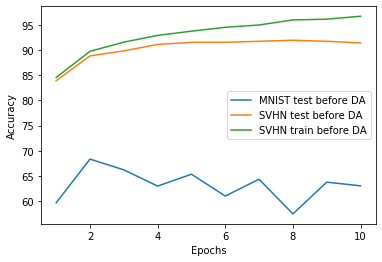

In [0]:
from matplotlib import pyplot as plt
plt.plot(list(range(1, epochs+1)), accuracy_mnist_test, label = "MNIST test before DA")
plt.plot(list(range(1, epochs+1)), accuracy_svhn_test, label = "SVHN test before DA")
plt.plot(list(range(1, epochs+1)), accuracy_svhn_train, label = "SVHN train before DA")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [0]:
print("max accuracy for mnist-test", max(accuracy_mnist_test))
print("max accuracy for svhn-test", max(accuracy_svhn_test))
print("max accuracy for svhn-train", max(accuracy_svhn_train))

max accuracy for mnist-test 68.33
max accuracy for svhn-test 91.94452980946528
max accuracy for svhn-train 96.71567222244973


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


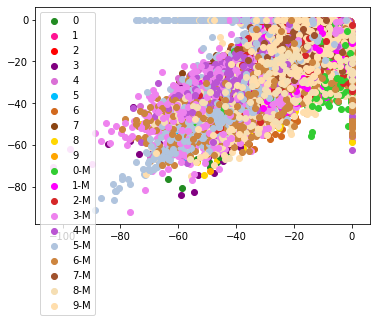

In [0]:
fig, ax = plt.subplots()

for batch_idx, (data, target) in enumerate(train_loader_svhn):
        data, target = data.to(device), target.to(device)
        output = model(data)
        bs = output.size(0)
        x = torch.svd(output)
        z = torch.eye(x[1].size(0))
        z = z * x[1]
        #z = x[2].unsqueeze(0).expand(data.size())
        x = torch.mm(x[0], z)[:,0:2]
        #print(x.size())
        colors = ["forestgreen", "deeppink", "red", "purple", "orchid", "deepskyblue", "chocolate", "saddlebrown", "gold", "orange"]
        for i in range(10):
            data_i = torch.masked_select(output, torch.unsqueeze(target == i, 1).expand(output.size())).view(-1,2)
            if batch_idx==0:
                ax.scatter(data_i[:,0].detach().numpy(), data_i[:,1].detach().numpy(), c=colors[i], label=i)
            else:
                ax.scatter(data_i[:,0].detach().numpy(), data_i[:,1].detach().numpy(), c=colors[i])
            #data_i = data.masked_select(torch.unsqueeze((target == i).float(), 1).expand(data.size()))

for batch_idx, (data, target) in enumerate(test_loader_mnist):
        data, target = data.to(device), target.to(device)
        output = model(data)
        bs = output.size(0)
        x = torch.svd(output)
        z = torch.eye(x[1].size(0))
        z = z * x[1]
        #z = x[2].unsqueeze(0).expand(data.size())
        x = torch.mm(x[0], z)[:,0:2]
        #print(x.size())
        colors = ["limegreen", "magenta", "tab:red", "violet", "mediumorchid", "lightsteelblue", "peru", "sienna", "wheat", "navajowhite"]
        for i in range(10):
            data_i = torch.masked_select(output, torch.unsqueeze(target == i, 1).expand(output.size())).view(-1,2)
            if batch_idx==0:
                ax.scatter(data_i[:,0].detach().numpy(), data_i[:,1].detach().numpy(), c=colors[i], label=str(i)+"-M")
            else:
                ax.scatter(data_i[:,0].detach().numpy(), data_i[:,1].detach().numpy(), c=colors[i])
            #data_i = data.masked_select(torch.unsqueeze((target == i).float(), 1).expand(data.size()))


plt.legend()
plt.show()

In [0]:
import numpy as np

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(10, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [0]:
batch_size = 40
test_batch_size = 40

train_loader_svhn = DataLoader(svhn_train,
                          batch_size=batch_size, shuffle=True)
test_loader_svhn = DataLoader(svhn_test,
                         batch_size=test_batch_size, shuffle=True)
test_loader_mnist = DataLoader(mnist_test,
                         batch_size=test_batch_size, shuffle=True)

In [0]:
weights_and_bias = list(model_cnn.parameters())
model_mnist_cnn = Net().to(device)
model_mnist_cnn.conv1.weight.data = weights_and_bias[0].clone().detach()
model_mnist_cnn.conv1.bias.data = weights_and_bias[1].clone().detach()
model_mnist_cnn.conv2.weight.data = weights_and_bias[2].clone().detach()
model_mnist_cnn.conv2.bias.data = weights_and_bias[3].clone().detach()
model_mnist_cnn.conv3.weight.data = weights_and_bias[4].clone().detach()
model_mnist_cnn.conv3.bias.data = weights_and_bias[5].clone().detach()
model_mnist_cnn.conv4.weight.data = weights_and_bias[6].clone().detach()
model_mnist_cnn.conv4.bias.data = weights_and_bias[7].clone().detach()
model_mnist_cnn.fc1.weight.data = weights_and_bias[8].clone().detach()
model_mnist_cnn.fc1.bias.data = weights_and_bias[9].clone().detach()
model_mnist_cnn.fc2.weight.data = weights_and_bias[10].clone().detach()
model_mnist_cnn.fc2.bias.data = weights_and_bias[11].clone().detach()
model_mnist_cnn.fc3.weight.data = weights_and_bias[12].clone().detach()
model_mnist_cnn.fc3.bias.data = weights_and_bias[13].clone().detach()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  del sys.path[0]


In [0]:
from torch.autograd import Variable
# Initialize generator and discriminator

lr = 0.00005
momentum = 0.5
log_interval = 700

discriminator = Discriminator().to(device)
#model_mnist_cnn = Net().to(device)
#print(model_cnn.parameters)
#model_mnist_cnn.set_weights(model_cnn.get_weights())
adversarial_loss = torch.nn.BCELoss()
optimizer_mnist = torch.optim.Adam(model_mnist_cnn.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)
Tensor = torch.Tensor#cuda.FloatTensor 
tiny_n_epochs = 5
n_epochs=100
accuracy_mnist_test_after = []
accuracy_svhn_test_after = []
accuracy_svhn_train_after = []
for epoch in range(n_epochs):   
    for i, data in enumerate(zip(train_loader_svhn, test_loader_mnist)):
        imgs = data[0][0]
        imgs2 = data[1][0]
        # Adversarial ground truths
        data, target = data[0][0].to(device), data[0][1].to(device)
        optimizer_mnist.zero_grad()
        output = model_mnist_cnn(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)
        # Configure input
        real_imgs = Variable(imgs.type(Tensor))
        #z = Variable(torch.randn((imgs2.shape[0])).to(device))
        gen_imgs = Variable(imgs2.type(Tensor))
        valid2 = Variable(Tensor(imgs2.size(0), 1).fill_(1.0), requires_grad=False)
        fake2 = Variable(Tensor(imgs2.size(0), 1).fill_(0.0), requires_grad=False)
        g_loss = adversarial_loss(discriminator(model_mnist_cnn(gen_imgs)), valid2)
        optimizer_mnist.zero_grad()
        g_loss.backward()
        optimizer_mnist.step()
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(model_cnn(real_imgs)), valid)
        fake_loss = adversarial_loss(discriminator(model_mnist_cnn(gen_imgs)), fake2)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
    acc_mnist_test_after = test(model_mnist_cnn, device, test_loader_mnist) #accuracy on test-mnist
    acc_svhn_test_after = test(model_mnist_cnn, device, test_loader_svhn) #accuracy on test-svhn
    acc_svhn_train_after = test(model_mnist_cnn, device, train_loader_svhn) #accuracy on train-svhn
    print(acc_mnist_test_after, acc_svhn_test_after, acc_svhn_train_after, d_loss)
    accuracy_mnist_test_after.append(acc_mnist_test_after)
    accuracy_svhn_test_after.append(acc_svhn_test_after)
    accuracy_svhn_train_after.append(acc_svhn_train_after)
    if epoch < 3:
        model_mnist_cnn.conv1.weight.data = weights_and_bias[0].clone().detach()
        model_mnist_cnn.conv1.bias.data = weights_and_bias[1].clone().detach()
        model_mnist_cnn.conv2.weight.data = weights_and_bias[2].clone().detach()
        model_mnist_cnn.conv2.bias.data = weights_and_bias[3].clone().detach()
        model_mnist_cnn.conv3.weight.data = weights_and_bias[4].clone().detach()
        model_mnist_cnn.conv3.bias.data = weights_and_bias[5].clone().detach()
        model_mnist_cnn.conv4.weight.data = weights_and_bias[6].clone().detach()
        model_mnist_cnn.conv4.bias.data = weights_and_bias[7].clone().detach()
        model_mnist_cnn.fc1.weight.data = weights_and_bias[8].clone().detach()
        model_mnist_cnn.fc1.bias.data = weights_and_bias[9].clone().detach()
        model_mnist_cnn.fc2.weight.data = weights_and_bias[10].clone().detach()
        model_mnist_cnn.fc2.bias.data = weights_and_bias[11].clone().detach()
        model_mnist_cnn.fc3.weight.data = weights_and_bias[12].clone().detach()
        model_mnist_cnn.fc3.bias.data = weights_and_bias[13].clone().detach()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


64.63 90.68070067609096 95.98673164339245 tensor(0.6611, grad_fn=<DivBackward0>)
68.93 90.99569760295022 95.71508524782615 tensor(0.6802, grad_fn=<DivBackward0>)
70.66 91.0417947141979 95.81473442810926 tensor(0.7441, grad_fn=<DivBackward0>)
71.2 91.01106330669944 95.8338452298074 tensor(0.7083, grad_fn=<DivBackward0>)
75.47 90.55393362015981 95.21820440367473 tensor(0.6955, grad_fn=<DivBackward0>)
76.91 90.2120467117394 94.43602659131551 tensor(0.6872, grad_fn=<DivBackward0>)
78.89 89.88936693300553 94.25993420423987 tensor(0.7407, grad_fn=<DivBackward0>)
78.13 90.2082052858021 94.46878796565515 tensor(0.6657, grad_fn=<DivBackward0>)
78.19 89.67808850645359 93.34807595178617 tensor(0.6181, grad_fn=<DivBackward0>)
79.62 88.25676090964966 91.14487352744447 tensor(0.6914, grad_fn=<DivBackward0>)
80.11 89.37077443146896 92.71332432395539 tensor(0.7036, grad_fn=<DivBackward0>)
78.31 88.909803318992 92.39253586687961 tensor(0.7371, grad_fn=<DivBackward0>)
72.48 85.93653964351567 89.14506463

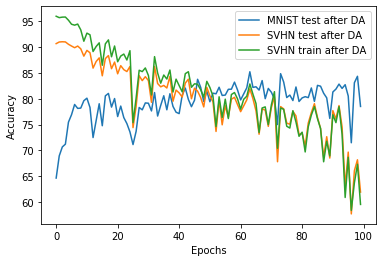

In [0]:
plt.plot(list(range(len(accuracy_mnist_test_after))), accuracy_mnist_test_after, label = "MNIST test after DA")
plt.plot(list(range(len(accuracy_mnist_test_after))), accuracy_svhn_test_after, label = "SVHN test after DA")
plt.plot(list(range(len(accuracy_mnist_test_after))), accuracy_svhn_train_after, label = "SVHN train after DA")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


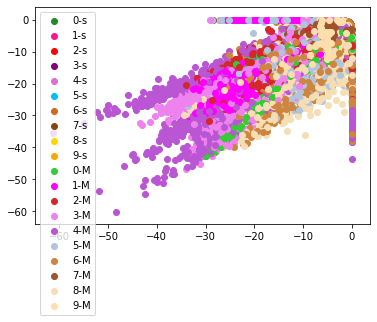

In [0]:
fig, ax = plt.subplots()

for batch_idx, (data, target) in enumerate(train_loader_svhn):
        data, target = data.to(device), target.to(device)
        output = model_mnist_cnn(data)
        bs = output.size(0)
        x = torch.svd(output)
        z = torch.eye(x[1].size(0))
        z = z * x[1]
        #z = x[2].unsqueeze(0).expand(data.size())
        x = torch.mm(x[0], z)[:,0:2]
        #print(x.size())
        colors = ["forestgreen", "deeppink", "red", "purple", "orchid", "deepskyblue", "chocolate", "saddlebrown", "gold", "orange"]
        for i in range(10):
            data_i = torch.masked_select(output, torch.unsqueeze(target == i, 1).expand(output.size())).view(-1,2)
            if batch_idx==0:
                ax.scatter(data_i[:,0].detach().numpy(), data_i[:,1].detach().numpy(), c=colors[i], label=str(i)+"-s")
            else:
                ax.scatter(data_i[:,0].detach().numpy(), data_i[:,1].detach().numpy(), c=colors[i])
            #data_i = data.masked_select(torch.unsqueeze((target == i).float(), 1).expand(data.size()))

for batch_idx, (data, target) in enumerate(test_loader_mnist):
        data, target = data.to(device), target.to(device)
        output = model_mnist_cnn(data)
        bs = output.size(0)
        x = torch.svd(output)
        z = torch.eye(x[1].size(0))
        z = z * x[1]
        #z = x[2].unsqueeze(0).expand(data.size())
        x = torch.mm(x[0], z)[:,0:2]
        #print(x.size())
        colors = ["limegreen", "magenta", "tab:red", "violet", "mediumorchid", "lightsteelblue", "peru", "sienna", "wheat", "navajowhite"]
        for i in range(10):
            data_i = torch.masked_select(output, torch.unsqueeze(target == i, 1).expand(output.size())).view(-1,2)
            if batch_idx==0:
                ax.scatter(data_i[:,0].detach().numpy(), data_i[:,1].detach().numpy(), c=colors[i], label=str(i)+"-M")
            else:
                ax.scatter(data_i[:,0].detach().numpy(), data_i[:,1].detach().numpy(), c=colors[i])
            #data_i = data.masked_select(torch.unsqueeze((target == i).float(), 1).expand(data.size()))


plt.legend()
plt.show()

In [0]:
print("max accuracy for mnist-test", max(accuracy_mnist_test_after))
print("max accuracy for svhn-test", max(accuracy_svhn_test_after))
print("max accuracy for svhn-train", max(accuracy_svhn_train_after))

max accuracy for mnist-test 85.23
max accuracy for svhn-test 91.0417947141979
max accuracy for svhn-train 95.98673164339245
